<a href="https://colab.research.google.com/github/guscldns/TestProject/blob/main/0706/09_1_image_augmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image Augmentation(증강)

In [ ]:
import os

import cv2
import numpy as np

from matplotlib import pyplot as plt
import matplotlib.cm as cm

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

import pickle
from tqdm.notebook import tqdm

## Download Dataset(데이터셋 다운로드받기)

In [ ]:
!pip install --upgrade --no-cache-dir gdown

  Attempting uninstall: gdown
    Found existing installation: gdown 4.6.6
    Uninstalling gdown-4.6.6:
      Successfully uninstalled gdown-4.6.6


In [ ]:
# x_train
!gdown 1uKn5KmcXMv4QUaIPz7wcc-my1mY1qrkk

# y_train
!gdown 11vtzegsqPhaLUMUhvkZ9lUNWDvcPWSVS

Downloading...
From (uriginal): https://drive.google.com/uc?id=1uKn5KmcXMv4QUaIPz7wcc-my1mY1qrkk
From (redirected): https://drive.google.com/uc?id=1uKn5KmcXMv4QUaIPz7wcc-my1mY1qrkk&confirm=t&uuid=02a7706d-92a9-4bf5-97ae-632ee9096a4d
To: /content/x_train.pickle
100% 779M/779M [00:04<00:00, 178MB/s]
Downloading...
From: https://drive.google.com/uc?id=11vtzegsqPhaLUMUhvkZ9lUNWDvcPWSVS
To: /content/y_train.pickle
100% 41.5k/41.5k [00:00<00:00, 113MB/s]


In [ ]:
with open('x_train.pickle', 'rb') as f:
    x_train = pickle.load(f)

with open('y_train.pickle', 'rb') as f:
    y_train = pickle.load(f)

In [ ]:
x_train.shape, y_train.shape

((5174, 224, 224, 3), (5174,))

## Trainset Augmentation

In [ ]:
# 훈련데이터 검증(Augmentation)
# ImageDataGenerator : 데이터를 가지고 와서 모델에게 붙일 때 사용하는 라이브러리
datagen = ImageDataGenerator(
    rotation_range=40,
    # 회전
    width_shift_range=0.2,
    # 수평 방향으로 이동
    height_shift_range=0.2,
    # 수직 방향으로 이동
    shear_range=0.2,
    # 사다리꼴로 기울임
    zoom_range=0.2,
    # 크고 작게
    horizontal_flip=True,
    # 수평 뒤집기
    vertical_flip=True,
    # 수직 뒤집기
)

ImageDataGenerator에는 아래와 같은 주요 어그멘테이션 함수가 있다.
- flow() : 4차원 numpy array를 입력받아 데이터 생성
    - 변수에 들어있는 4차원 numpy array 데이터를 가져와서 데이터 생성
    - 4차원 = 데이터 배치 개수, width, height, chanel
- flow_from_dataframe() : 데이터프레임에서 이미지 경로와 해당 이미지의 라벨을 입력받아 데이터 생성
    - 전제 : 데이터프레임에서 이미 이미지 경로/ 이미지 라벨이 정리된 상태
    - CSV 파일인 경우에도 사용 가능
    - 이미지 파일 이름/ 이미지 라벨만 정제된 상태라면 이미지 경로를 붙여줘야 한다 (특정 컬럼을 일괄 수정하는 방법은 pandas에 있음)
    - 장점: 레포지터리에 들어있다면 저장공간만 사용하고 램은 사용하지 않는다
        - 변수에 데이터가 있다 = 램을 사용한다
- flow_from_directory() : 디렉토리에서 하위 디렉토리(폴더)를 라벨로, 그 하위 파일들을 해당 라벨의 이미지라고 간주하여 라벨과 이미지를 입력받아 데이터 생성 (*아래 첨부 이미지 참고)
    -

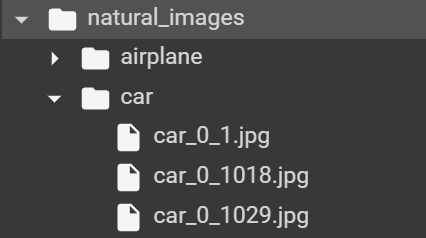

아래 코드에서는 flow()를 이용한다.

In [ ]:
index2label = {0:'airplane', 1:'car', 2:'cat', 3:'dog',
               4:'flower', 5:'fruit', 6:'motorbike', 7:'person'}

In [ ]:
# !rm -r /content/car # -r : recursive(하위 디렉토리, 파일까지 삭제)
# !rm -r /content/fruit

In [ ]:
os.mkdir('/content/aumented')
for label in index2label.values():
    dir_path = '/content/aumented/'+ label
    os.mkdir(dir_path)

FileExistsError: ignored

In [ ]:
x_train, y_train = list(x_train), list(y_train)
x_augmented, y_augmented = [], []

In [ ]:
aug_cnt = 1

for img, label_idx in zip(tqdm(x_train), y_train):
    x = img_to_array(img)
    x = x.reshape((1,) + x.shape)
    # x.shape = tuple 형태, shape는 array라서 가능, 튜플끼리 덧셈도 가능
    # reshape : size를 변경하지 않는 범위 내에서 shape를 변환시켜주는 함수, size를 바꿀 수는 없다
    # resize : size 변환

    label = index2label[label_idx] # 경로 핸들링 위함
    # label2index : 라벨을 인덱스로 변경
    # index2label : 경로 핸들링 위함
    dir_path = '/content/aumented/'+ label

    i = 0
    # flow : augmentation 함수
    # batch에 flow된 데이터가 들어감
    for batch in datagen.flow(x, batch_size=1,
                            save_to_dir=dir_path, save_prefix=label, save_format='jpg'):

        # x : 4차원
        # save_to_dir=dir_path : flow를 실행시키면 dir_path에 augmentation한 결과 저장해주겠다
        # save_prefix=label: 저장할 때 파일명 앞에 라벨을 붙여주겠다
        x_augmented.append(batch[0])
        # x_augmented 변수에도 저장(선택), batch[0] : 4차원이라서 0번째 값 저장
        y_augmented.append(label_idx)
        # label_idx : 라벨로 바꾸기 전 숫자를 저장
        i += 1
        if i == aug_cnt: # while문 처럼 쓴 이유 : flow 돌리면 계속 돌아가서 멈추는 시점 정해줘야 한다
            # aug_cnt =1 이라서 1장 저장
            break



  0%|          | 0/5174 [00:00<?, ?it/s]

In [ ]:
x_train += x_augmented
y_train += y_augmented

In [ ]:
x_train, y_train = np.array(x_train), np.array(y_train)

In [ ]:
x_train.shape, y_train.shape

((10348, 224, 224, 3), (10348,))

## 데이터 저장

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# 각자 원하는 드라이브 경로에 맞게 수정합시다.
folder_path = '/content/drive/MyDrive/LectureSpace/OpenDataset/pre_natural_imgs/'

In [ ]:
with open(folder_path+'x_train_aug.pickle', 'wb') as f:
    pickle.dump(x_train, f)

In [ ]:
with open(folder_path+'y_train_aug.pickle', 'wb') as f:
    pickle.dump(y_train, f)